In [104]:
import metpy.calc as mpcalc
from metpy.constants import g, Cp_d, Lv, Rd
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [105]:
date = datetime(2002, 11, 11, 0)
station = 'BNA'

df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values * units(df.units['pressure'])
temperature = df['temperature'].values * units(df.units['temperature'])
dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])
heights = df['height'].values * units(df.units['height'])

In [166]:
class massEnergyPlot(object):
    
    def __init__(self, fig=None, ax=None):
        # Setup figure and axes if we don't have them
        if fig is None:
            fig = plt.figure(figsize=(11,8))
        if ax is None:
            ax = plt.subplot(1, 1, 1)
        self.fig = fig
        self.ax = ax
        
        # Set default axis limits
        self.ax.set_xlim(250, 400)
        self.ax.set_ylim(1050, 100)

    def isohumes(self, values=np.arange(10, 100, 10) * units.percent, label=True, label_position=800 * units.hPa):
        # TODO: 
        # - Take user kwargs for plot line style and label style
        
        # Add lines of constant RH
        idx = np.argmin(np.abs(p - label_position))
        for rh in np.arange(10, 100, 10) * units.percent:
            self.ax.plot( s + Lv * qs * rh, p, linewidth=0.5, linestyle=':', color='black')
            # Add labels for the RH values
            if label:
                self.ax.annotate(rh.m, xy=( (s[idx]+Lv*qs[idx]*rh).to('kJ/kg'), label_position),                    
                        horizontalalignment='center',fontsize=8)
                
    def shade_precipitable_water(self, pressure, moist_static_energy, dry_static_energy):
        self.ax.fill_betweenx(pressure, moist_static_energy, dry_static_energy, where=dry_static_energy>moist_static_energy, facecolor='tab:blue', alpha=0.4)

    def rce_reference(self, xloc=260 * units('kJ/kg'), yloc=1045 * units.hPa):
        """Reference line for radiative convective equilibrium."""
        self.ax.plot(np.ones((2)) * xloc, [0, 1100]*units.hPa, linewidth=0.5)
        self.ax.annotate('Daily RCE', xy=(xloc, yloc), horizontalalignment='center')
    
    def radiative_cooling_reference(self, xloc=260 * units('kJ/kg')):
        x_points = np.array([xloc, xloc - (1.3 * units('kJ/kg')), xloc - (1.3 * units('kJ/kg')), xloc, xloc ])
        y_points = np.array([1000 , 1000    , 200     , 200, 1000]) * units.hPa
        self.ax.fill(x_points, y_points, linewidth=1, color='c', alpha=0.9)

        self.ax.annotate('Cooling $-1.3 K/d$',  xy=(RCEloc, 300), color='c')
        self.ax.annotate('$-10^7 J m^{-2}$', xy=(RCEloc, 330))
    
    def internal_waves(self, pressure, amplitude=100*units.m, levels=np.arange(900, 100, -100) * units.hPa):
        # TODO:
        # - line plotting parameters

        for level in levels:
            print(level)
            idx = np.argmin(np.abs(pressure - level))
            
            # Wave temperature change
            wave_dT = -g / Cp_d * amplitude
            displaced_temperature = temperature[idx] + wave_dT.to('delta_degC')
    
            # Wave pressure change
            density = pressure[idx] / Rd / temperature[idx]
            wave_dp = -density * g * amplitude
            
            # dhsat
            dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(displaced_temperature), 
                                      pressure[idx] + wave_dp) - qs[idx]
            dhs = g * amplitude + Cp_d * wave_dT + Lv * dqs
            
            # Plot internal waves
            colors = ['tab:red', 'tab:red', 'tab:blue']
            for var, color in zip([hs + dhs, s, h], colors):
                x_vals = [var[idx] * (1*var.units), var[idx] * (1*var.units)]
                y_vals = [-1*(pressure[idx] + wave_dp), (pressure[idx] + wave_dp)]
                #self.ax.plot((var[idx] * (-1, 1)).to('kJ/kg'), pressure[idx] + wave_dp * (-1, 1), linewidth=3, color=color)    
                self.ax.plot(x_vals, y_vals, linewidth=3, color=color)    

ValueError: setting an array element with a sequence.

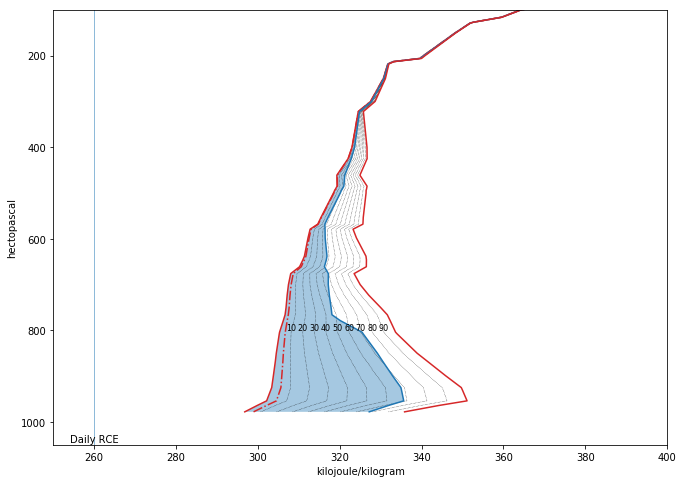

In [167]:
mep = massEnergyPlot()
mep.isohumes()

# Calculate mixing ratios
q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(dewpoint), pressure)
qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(temperature), pressure)

# Calculate variables to plot
s = (g * heights + Cp_d * temperature).to('kJ/kg')
sv = (g * heights + Cp_d * mpcalc.virtual_temperature(T, q)).to('kJ/kg')
h = (s + Lv * q).to('kJ/kg')
hs = (s + Lv * qs).to('kJ/kg')

# Plot the sounding data
mep.ax.plot(s, p, color='tab:red', linewidth=1.5)
mep.ax.plot(sv, p, color='tab:red', linestyle='-.')
mep.ax.plot(h, p, color='tab:blue', linewidth=1.5)
mep.ax.plot(hs, p, color='tab:red', linewidth=1.5)
mep.shade_precipitable_water(p, s, h)
mep.rce_reference()
mep.radiative_cooling_reference()
#mep.internal_waves(pressure)

In [117]:
dt = -g / Cp_d * 100 * units.m

In [99]:
(270 * units.degK).to('delta_degF')

<Quantity(485.99999999999994, 'delta_degF')>

In [80]:
dt

<Quantity(-0.9757860696517412, 'kelvin')>

In [136]:
q

<Quantity([  1.21628242e-02   1.28308557e-02   1.33951131e-02   1.27894702e-02
   1.26254248e-02   1.16301119e-02   1.04895612e-02   9.88182109e-03
   8.19746465e-03   8.06555793e-03   5.56755465e-03   4.58049006e-03
   4.40620165e-03   4.12001899e-03   3.88872011e-03   3.67555514e-03
   2.42396527e-03   2.28892367e-03   2.20735244e-03   1.67779817e-03
   1.46259327e-03   6.93531326e-04   6.86070379e-04   6.66181425e-04
   6.61704693e-04   6.65074033e-04   6.61402269e-04   7.78862917e-04
   3.10996814e-04   2.57420863e-04   1.24233094e-04   9.62298231e-05
   5.01790167e-05   2.41079920e-05   2.75123723e-05   4.47071766e-05
   4.03864986e-05   1.54346984e-05   9.27754710e-06   9.13765414e-06
   1.27752269e-05   9.33346594e-06   1.05037110e-05   9.29104007e-06
   3.22651961e-05   2.65443676e-05   3.71567078e-05   5.94923200e-05
   5.05342641e-05   9.82749364e-05   1.52712025e-04   3.37509656e-04
   4.82334894e-04], 'millibar / hectopascal')>

In [169]:
xloc = 260 * units('kJ/kg')
y = xloc - (1.3 * units('kJ/kg'))

In [170]:
print(y)

258.7 kilojoule / kilogram


In [171]:
a = np.array([y, y])

ValueError: setting an array element with a sequence.

In [172]:
a = np.array([xloc, xloc])

ValueError: setting an array element with a sequence.